In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

In [ ]:
np.sqrt(0.0010)

0.03162277660168379

In [ ]:
# Mount Google Drive and set the working directory
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
os.chdir("/content/gdrive/Shareddrives/STA 221/data")


Mounted at /content/gdrive/


In [ ]:
# Load the dataset
file_name = 'train_knn_imputed_final_with_1hot_encoding.csv'
data = pd.read_csv(file_name)

In [ ]:
# Define the prefixes you want to keep
included_prefixes = ('bg', 'cals', 'insulin', 'carbs', 'hr', 'steps')

In [ ]:
# Select only the columns starting with the specified prefixes
feature_columns = [col for col in data.columns if col.startswith(included_prefixes)]

In [ ]:
# Separate features (X) and target (y)
# Assuming 'bg+1:00' is the target variable
X = data[feature_columns]
y = data["bg+1:00"]

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
# Initialize the models
first_stage_tree = DecisionTreeRegressor(max_depth=5, random_state=42)

# Initialize the second-stage AdaBoost model with a DecisionTreeRegressor as the base estimator
second_stage_boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=50, random_state=42)

In [ ]:
# Initialize K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
mae_scores = []
mse_scores = []
r2_scores = []

In [ ]:
# Cross-validation loop
for train_index, val_index in kf.split(X_train_scaled):
    # Split into training and validation sets
    X_train_cv, X_val_cv = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the first-stage Decision Tree model
    first_stage_tree.fit(X_train_cv, y_train_cv)

    # Generate predictions for training and validation sets
    tree_output_train = first_stage_tree.predict(X_train_cv)
    tree_output_val = first_stage_tree.predict(X_val_cv)

    # Add Decision Tree predictions as new features
    X_train_ext = X_train_cv.copy()
    X_val_ext = X_val_cv.copy()
    X_train_ext["tree_output"] = tree_output_train
    X_val_ext["tree_output"] = tree_output_val

    # Train the second-stage AdaBoost model
    second_stage_boost.fit(X_train_ext, y_train_cv)

    # Predict on the validation set
    final_predictions = second_stage_boost.predict(X_val_ext)

    # Calculate regression metrics
    mae_scores.append(mean_absolute_error(y_val_cv, final_predictions))
    mse_scores.append(mean_squared_error(y_val_cv, final_predictions))
    r2_scores.append(r2_score(y_val_cv, final_predictions))

In [ ]:
# Final evaluation on the test set
# Train the entire pipeline on the training set
first_stage_tree.fit(X_train_scaled, y_train)
tree_output_train = first_stage_tree.predict(X_train_scaled)
tree_output_test = first_stage_tree.predict(X_test_scaled)

X_train_ext = X_train_scaled.copy()
X_test_ext = X_test_scaled.copy()
X_train_ext["tree_output"] = tree_output_train
X_test_ext["tree_output"] = tree_output_test

second_stage_boost.fit(X_train_ext, y_train)
test_predictions = second_stage_boost.predict(X_test_ext)

# Calculate metrics on the test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

In [ ]:
# Display results
print("Cross-Validation Metrics on Training Set:")
print(f"Mean Absolute Error (MAE): {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean Squared Error (MSE): {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"R² Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

print("\nMetrics on Test Set:")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"R² Score: {test_r2:.4f}")

Cross-Validation Metrics on Training Set:
Mean Absolute Error (MAE): 0.0242 ± 0.0016
Mean Squared Error (MSE): 0.0009 ± 0.0001
R² Score: 0.9916 ± 0.0009

Metrics on Test Set:
Mean Absolute Error (MAE): 0.0250
Mean Squared Error (MSE): 0.0010
R² Score: 0.9911


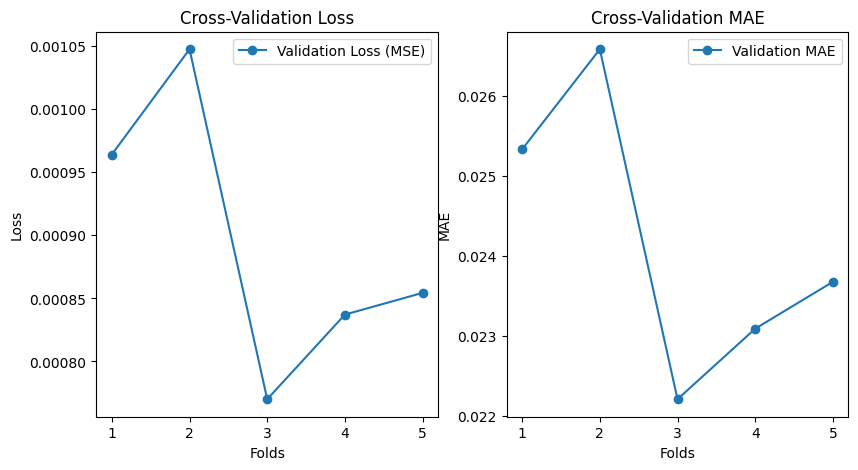

In [ ]:
# Plotting the results
folds = np.arange(1, len(mae_scores) + 1)

# Loss and MAE graphs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(folds, mse_scores, label='Validation Loss (MSE)', marker='o')
plt.title('Cross-Validation Loss')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(folds, mae_scores, label='Validation MAE', m arker='o')
plt.title('Cross-Validation MAE')
plt.xlabel('Folds')
plt.ylabel('MAE')
plt.legend()

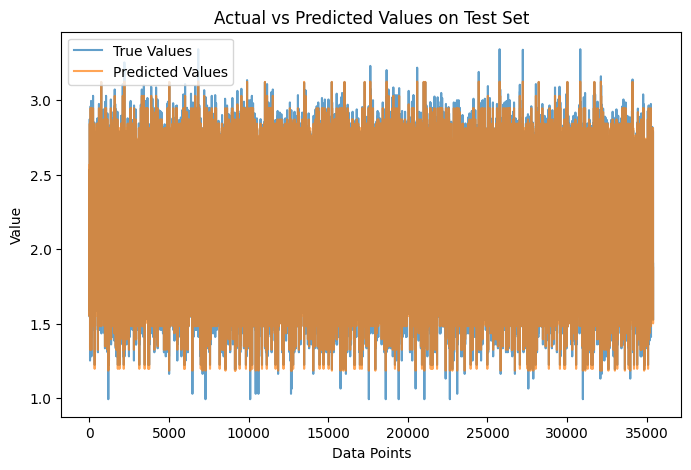

In [ ]:
# Actual vs Predicted Values
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='True Values', alpha=0.7)
plt.plot(test_predictions, label='Predicted Values', alpha=0.7)
plt.title('Actual vs Predicted Values on Test Set')
plt.xlabel('Data Points')  # Updated from 'Samples' to 'Data Points'
plt.ylabel('Value')
plt.legend()
plt.show()